## TaskC.3.a Streaming Visualisation
The basis of this code is week 11 Kafka_consumer_04

In [1]:
# import statements
from time import sleep
import json
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import statistics


## Graph functions
functions to annotate and initialize graphing.

In [2]:
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax = fig.add_subplot(111)
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        fig.suptitle('Real time air temperature against arrival time') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
        
def graph(fig,ax,x,y,average):

        ax.clear()
        ax.plot(x, y)
        ax.plot(x, average)
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_title('Creation Time Vs Value')
        ax.set_ylim(0,40) 
        ax.set_yticks([0,5,10,15,20,25,30,35,40])
        annotate_max(x, y, ax)
        annotate_min(x, y, ax)

        fig.canvas.draw()

## Kafka Consumer Code
This contains the main logic for consuming the message and populating arrays for a graph.

In [3]:
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   key_deserializer=lambda m : m.decode('utf-8'),
                                   value_deserializer=lambda m : json.loads(m.decode('utf-8')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer


    
def consume_messages(consumer, fig, ax, delay = 0):
    try:
        
        # container for values
        time, temperature, average = [], [], []
        print('Waiting for messages')
        for message in consumer:
            if (message.key != key):
                continue
            time_only = message.value['create_date'].split(" ")[1]
            time.append(time_only) 
            temperature.append(float(message.value['air_temperature_celcius']))
            
            if len(temperature) > 5:
                average.append(statistics.mean(temperature[:5]))
            else:
                average.append(0)
                
            # we start plotting only when we have 10 data points
           
            graph(fig,ax,time,temperature,average)
            
            if len(temperature) > window:
                time.pop(0) # removing the item in the first position
                temperature.pop(0)
                average.pop(0)
            
            sleep(delay)
            
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    

<IPython.core.display.Javascript object>


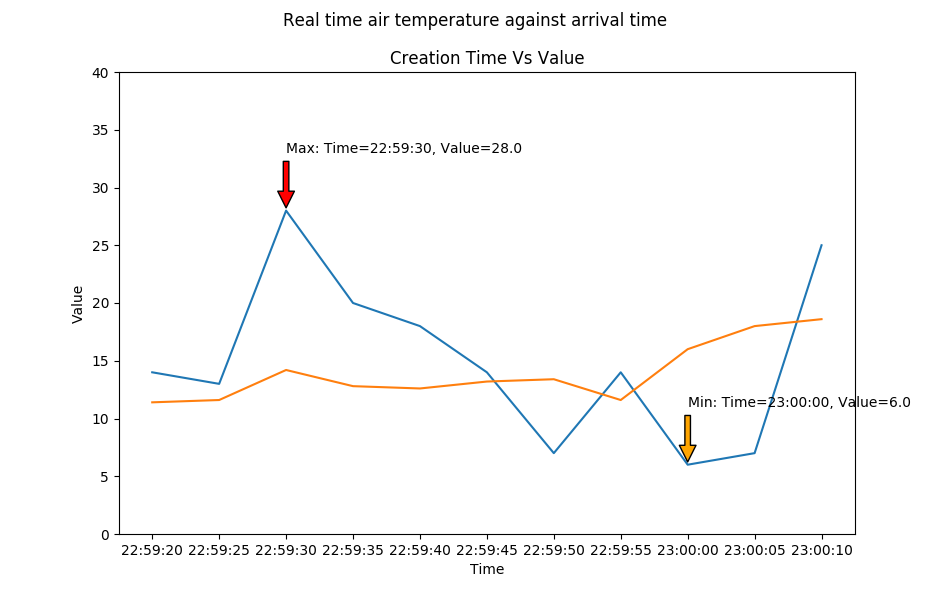

Waiting for messages
ended


In [5]:
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

# slow down the rate of the graph
delay = 0.25

# max points to have
window = 10

topic = 'ClimateData'
key = 'climate'
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    print("ended")

## TaskC.3.b Static Visualisation
This part is performed based on the records from TaskC.2

### Top 10 number of fires
This bar chart shows the records with top 10 number of fires happening in 5 minutes.

x-axis - time_interval

y-axis - number of fires

In [8]:
from pymongo import MongoClient
from pprint import pprint

client = MongoClient()
db = client.fit5148_assignment
collStream = db.stream

# how large of a period to group data by in minutes.
aggregate_period = 5

# the number of top records to pull
limit = 10

# retreive top <limit> number of fires happening in a time interval of <aggregate_period> minutes.
results = collStream.aggregate(
    [
        {
            "$unwind" : "$fire"
        },
        { 
            "$group": {
                "_id": 
                {
                    "time_interval" : 
                    {
                        "$dateFromParts":{
                            "year": {"$year": "$fire.time"},
                            "month": {"$month" : "$fire.time"},
                            "day": {"$dayOfMonth" : "$fire.time"},
                            "hour": {"$hour" : "$fire.time"},
                            "minute": { "$subtract" : [
                                {"$minute":"$fire.time"},
                                {"$mod":[{"$minute":"$fire.time"}, aggregate_period]}
                            ]}
                        }
                    }
                },
                "fire_count": { "$sum": 1 }
            }
        },
        {
            "$project":{
                "time_interval": "$_id.time_interval",
                "fire_count":1,
                "_id":0
            }
        },
        {
            "$sort":{"fire_count":-1}
        },
        {
            "$limit":limit
        }
    ]
)

record_list = []
for r in results:
    pprint(r)
    record_list.append(r)

{'fire_count': 3, 'time_interval': datetime.datetime(2019, 5, 21, 21, 50)}
{'fire_count': 2, 'time_interval': datetime.datetime(2019, 5, 21, 22, 30)}
{'fire_count': 2, 'time_interval': datetime.datetime(2019, 5, 21, 21, 45)}
{'fire_count': 1, 'time_interval': datetime.datetime(2019, 5, 21, 22, 35)}
{'fire_count': 1, 'time_interval': datetime.datetime(2019, 5, 21, 22, 5)}
{'fire_count': 1, 'time_interval': datetime.datetime(2019, 5, 21, 22, 0)}
{'fire_count': 1, 'time_interval': datetime.datetime(2019, 5, 21, 21, 40)}
{'fire_count': 1, 'time_interval': datetime.datetime(2019, 5, 21, 21, 55)}


<IPython.core.display.Javascript object>


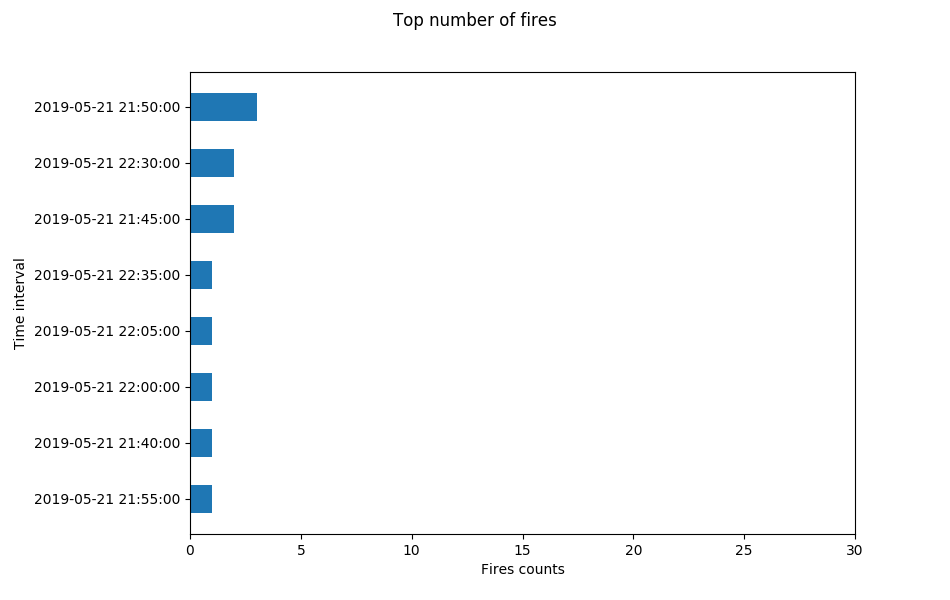

In [9]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook
time_interval_list = []
fire_count_list = []
for r in record_list:
    # date is split into time only so it fits into the axis labels
    time_interval_list.append(r['time_interval'])
    fire_count_list.append(r['fire_count'])

# draw the bar chart
width = 9.5
height = 6
fig = plt.figure(figsize=(width,height)) # create new figure
ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
fig.suptitle('Top number of fires') # giving figure a title

ax.set_ylabel('Time interval') # set x lable
ax.set_xlabel('Fires counts') # set y lable
ax.set_xlim(0,30) # set y range
ax.set_xticks([0,5,10,15,20,25,30])

y = range(len(time_interval_list))
x = fire_count_list
ax.invert_yaxis()
plt.yticks(y, time_interval_list,fontsize=10) # set x range
plt.barh(y, x, height = 0.5) # set bar chart
plt.subplots_adjust(left=0.2)


fig.show()


### Plot Fire Location

Plot fire locations in the map with air temperature, surface temperature, relative humidity and confidence.

In [10]:
import gmplot
# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 10) # latitude and longitude of melbourne city

In [11]:
from pymongo import MongoClient
from pprint import pprint

client = MongoClient()
db = client.fit5148_assignment
collStream = db.stream

# get required data from database
results = collStream.aggregate(
    [
        {
            "$unwind":'$fire'
        },
        {
            "$project":
            {
                "fire.confidence":1,
                "fire.latitude":1,
                "fire.longitude":1,
                "fire.surface_temperature_celcius":1,
                "air_temperature_celcius":1,
                "relative_humidity":1,
                "_id":0
            }
         }
    ]
)

record_list = []
for r in results:
    record_list.append(r)
#    pprint(r)

In [12]:
# add marker to map
for record in record_list:
    latitude = record['fire']['latitude']
    longitude = record['fire']['longitude']
    air_tem = record['air_temperature_celcius']
    sur_tem = record['fire']['surface_temperature_celcius']
    confidence = record['fire']['confidence']
    humidity = record['relative_humidity']
    
    title_string = "air temp: {}, surface_temp: {}, confidence: {}, relative humidity {}".format(air_tem,sur_tem,confidence,humidity)
    
    gmap.marker(latitude, longitude, title = title_string)


In [13]:
import webbrowser
# Drawing the map
gmap.draw("hotspots.html")
webbrowser.open_new("hotspots.html")

True